In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.set_option("display.max_column", 10)

/Users/conorohalloran/pardev/ChiFinesse/march_madness/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load the data!

In [2]:
YEAR = 2022
DATA_DIR = f'../../data/{YEAR}/MDataFiles_Stage2/'


In [3]:
tourney_results = pd.read_csv(f'{DATA_DIR}MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv(f'{DATA_DIR}MNCAATourneySeeds.csv')
regular_results = pd.read_csv(
    f'{DATA_DIR}MRegularSeasonDetailedResults.csv')


In [4]:
tourney_results.shape

(1181, 34)

In [5]:
seeds.shape

(2422, 3)

In [6]:
regular_results.shape

(102032, 34)

In [7]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1272,70,1393,...,7,12,8,6,16
2,2003,11,1266,73,1437,...,9,12,2,5,23
3,2003,11,1296,56,1457,...,9,19,4,3,23
4,2003,11,1400,77,1208,...,12,10,7,1,14


In [8]:
regular_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,...,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,...,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,...,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,...,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,...,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,...,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,...,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,...,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.741212,1289.607638,74.652480,1279.997910,62.484325,...,11.194376,14.431693,6.137374,2.888087,19.872126
2011,70.881243,1285.244758,74.374190,1283.078727,62.470644,...,11.180518,14.131910,5.933283,2.961685,20.081395


In [9]:
tourney_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,...,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,...,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,...,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,...,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,...,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,...,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,...,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,...,11.703125,12.593750,5.953125,3.234375,19.593750
2010,139.156250,1287.031250,74.031250,1313.937500,63.328125,...,11.421875,12.234375,6.140625,3.000000,19.125000
2011,138.955224,1270.089552,73.194030,1299.208955,61.910448,...,11.447761,11.656716,5.701493,2.820896,18.313433


In [10]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [11]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,...,16,15,5,0,22
1,2003,136,1112,80,1436,...,12,17,10,3,15
2,2003,136,1113,84,1272,...,11,12,2,5,18
3,2003,136,1141,79,1166,...,20,21,6,6,21
4,2003,136,1143,76,1301,...,16,14,5,8,19


In [12]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [13]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [14]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [15]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1272,70,1393,...,7,12,8,6,16
2,2003,11,1266,73,1437,...,9,12,2,5,23
3,2003,11,1296,56,1457,...,9,19,4,3,23
4,2003,11,1400,77,1208,...,12,10,7,1,14


In [16]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,...,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,...,13,23,7,1,22
1,2003,10,1393,63,1272,...,16,13,4,4,18
2,2003,11,1437,61,1266,...,15,10,5,2,25
3,2003,11,1457,50,1296,...,11,12,14,2,18
4,2003,11,1208,71,1400,...,12,14,4,4,20


In [17]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [18]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1272,70,1393,...,7,12,8,6,16
2,2003,11,1266,73,1437,...,9,12,2,5,23
3,2003,11,1296,56,1457,...,9,19,4,3,23
4,2003,11,1400,77,1208,...,12,10,7,1,14


In [19]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,...,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,...,13,23,7,1,22
1,2003,10,1393,63,1272,...,16,13,4,4,18
2,2003,11,1437,61,1266,...,15,10,5,2,25
3,2003,11,1457,50,1296,...,11,12,14,2,18
4,2003,11,1208,71,1400,...,12,14,4,4,20


In [20]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [21]:
regular_results.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1272,70,1393,...,7,12,8,6,16
2,2003,11,1266,73,1437,...,9,12,2,5,23
3,2003,11,1296,56,1457,...,9,19,4,3,23
4,2003,11,1400,77,1208,...,12,10,7,1,14


In [22]:
regular_results_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,...,13,23,7,1,22
1,2003,10,1393,63,1272,...,16,13,4,4,18
2,2003,11,1437,61,1266,...,15,10,5,2,25
3,2003,11,1457,50,1296,...,11,12,14,2,18
4,2003,11,1208,71,1400,...,12,14,4,4,20


In [23]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [24]:
regular_data.head(10)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,...,8,18,9,2,20
1,2003,10,1328,62,1104,...,13,23,7,1,22
2,2003,10,1272,70,1393,...,7,12,8,6,16
3,2003,10,1393,63,1272,...,16,13,4,4,18
4,2003,11,1266,73,1437,...,9,12,2,5,23
5,2003,11,1437,61,1266,...,15,10,5,2,25
6,2003,11,1296,56,1457,...,9,19,4,3,23
7,2003,11,1457,50,1296,...,11,12,14,2,18
8,2003,11,1400,77,1208,...,12,10,7,1,14
9,2003,11,1208,71,1400,...,12,14,4,4,20


In [25]:
tourney_results = pd.read_csv(f'{DATA_DIR}MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv(f'{DATA_DIR}MNCAATourneySeeds.csv')
regular_results = pd.read_csv(
    f'{DATA_DIR}MRegularSeasonDetailedResults.csv')

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [26]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [27]:
regular_data.shape

(204064, 35)

In [28]:
tourney_data.shape

(2362, 35)

In [29]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
2357,2021,148,1425,66,1211,...,9,6,3,16,-19
2358,2021,148,1276,49,1417,...,8,5,2,14,-2
2359,2021,152,1222,59,1124,...,8,6,0,18,-19
2360,2021,152,1417,90,1211,...,10,8,3,16,-3
2361,2021,154,1211,70,1124,...,7,8,5,19,-16


In [30]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,...,18,9,2,20,6
1,2003,10,1272,70,1393,...,12,8,6,16,7
2,2003,11,1266,73,1437,...,12,2,5,23,12
3,2003,11,1296,56,1457,...,19,4,3,23,6
4,2003,11,1400,77,1208,...,10,7,1,14,6


In [31]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,...,15,5,0,22,8
1,2003,136,1112,80,1436,...,17,10,3,15,29
2,2003,136,1113,84,1272,...,12,2,5,18,13
3,2003,136,1141,79,1166,...,21,6,6,21,6
4,2003,136,1143,76,1301,...,14,5,8,19,2


# Feature engineering!

In [32]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [33]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [34]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  ...  \
                       mean       mean      mean       mean       mean  ...   
Season T1_TeamID                                                        ...   
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571  ...   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778  ...   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429  ...   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000  ...   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714  ...   

                     T2_Ast      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean       mean      mean      mean      mean  
Season T1_TeamID                                                      
2003   1102        9.142857  12.964286  5.428571  1.571429  0.250000  
       1103       15.481481  15.333333  6.407407  2.851852  0.629630  
       1104       11.678571  13.857143  5.535714  3.178571  4.285714  
       1105       15.807692  18.807692  9.384615  4.192308 -4.884615  
       1106       11.785714  15.071429  8.785714  3.178571 -0.142857  

[5 rows x 19 columns]

In [35]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,...,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,...,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,...,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,...,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,...,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,...,11.785714,15.071429,8.785714,3.178571,-0.142857


In [36]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,...,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,...,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,...,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,...,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,...,11.785714,15.071429,8.785714,3.178571,-0.142857


In [37]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [38]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,...,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,...,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,...,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,...,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,...,11.785714,15.071429,8.785714,3.178571,-0.142857


In [39]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,...,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,...,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,...,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,...,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,...,11.785714,15.071429,8.785714,3.178571,-0.142857


In [40]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,...,15,5,0,22,8
1,2003,136,1112,80,1436,...,17,10,3,15,29
2,2003,136,1113,84,1272,...,12,2,5,18,13
3,2003,136,1141,79,1166,...,21,6,6,21,6
4,2003,136,1143,76,1301,...,14,5,8,19,2


In [41]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [42]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [43]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,...,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,...,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,...,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,...,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,...,12.566667,14.633333,7.433333,2.833333,4.400000


In [44]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [45]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [46]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean',
       'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T1_PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d',
       'T2_win_ratio_14d'],
      dtype='object')

In [47]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(11044, 5)

In [48]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [49]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
2357,2021,148,1425,66,1211,...,6.000000,2.884615,23.000000,0.75,1.0
2358,2021,148,1276,49,1417,...,5.076923,2.769231,4.346154,0.40,0.0
2359,2021,152,1222,59,1124,...,6.166667,3.833333,17.958333,1.00,0.8
2360,2021,152,1417,90,1211,...,6.000000,2.884615,23.000000,0.00,1.0
2361,2021,154,1211,70,1124,...,6.166667,3.833333,17.958333,1.00,0.8


In [50]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [51]:
seeds.tail()

,Season,Seed,TeamID
2417,2022,Z13,1151
2418,2022,Z14,1255
2419,2022,Z15,1174
2420,2022,Z16a,1136
2421,2022,Z16b,1460


In [52]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [53]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [54]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [55]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed
2357,2021,148,1425,66,1211,...,23.000000,0.75,1.0,6,1
2358,2021,148,1276,49,1417,...,4.346154,0.40,0.0,1,11
2359,2021,152,1222,59,1124,...,17.958333,1.00,0.8,2,1
2360,2021,152,1417,90,1211,...,23.000000,0.00,1.0,11,1
2361,2021,154,1211,70,1124,...,17.958333,1.00,0.8,1,1


In [56]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [57]:
tourney_data[tourney_data["Seed_diff"] == 0]

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,...,1.00,0.833333,16,16,0
64,2004,134,1197,72,1250,...,0.60,1.000000,16,16,0
128,2005,134,1324,79,1105,...,1.00,0.666667,16,16,0
191,2005,154,1314,75,1228,...,0.75,0.800000,1,1,0
192,2006,134,1284,71,1214,...,0.75,0.666667,16,16,0
...,...,...,...,...,...,...,...,...,...,...,...
2296,2021,136,1455,52,1179,...,0.75,0.500000,11,11,0
2297,2021,136,1111,53,1313,...,1.00,1.000000,16,16,0
2298,2021,136,1291,52,1411,...,1.00,1.000000,16,16,0
2299,2021,136,1277,80,1417,...,0.50,0.000000,11,11,0


# Time to build some models!

In [58]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2362.000000
mean        0.000000
std        14.382504
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [59]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"]

len(features)

43

In [60]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [61]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [62]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [63]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[15:58:35] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-yx400iye/xgboost_bedfee28942a42ba9b6ebf87775b6d25/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:58:35] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-yx400iye/xgboost_bedfee28942a42ba9b6ebf87775b6d25/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Pleas

In [64]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([129, 130, 150], [8.906697600000001, 8.8957612, 8.912868])

In [65]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[15:58:54] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-yx400iye/xgboost_bedfee28942a42ba9b6ebf87775b6d25/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:58:55] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-yx400iye/xgboost_bedfee28942a42ba9b6ebf87775b6d25/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Pleas

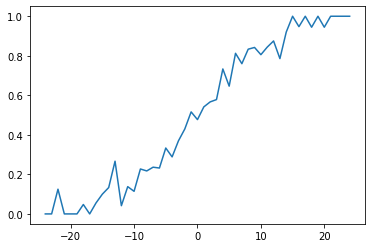

In [66]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [67]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5476187148521622
logloss of cvsplit 1: 0.5468146794709156
logloss of cvsplit 2: 0.5477496387950985


/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/ipykernel_4073/1482360335.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()


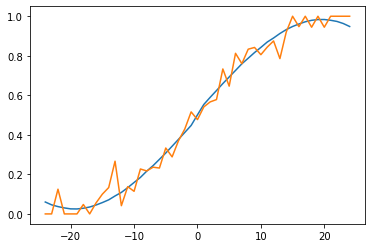

In [68]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [69]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5475463636688195
adjusted logloss of cvsplit 1: 0.5468633155472583
adjusted logloss of cvsplit 2: 0.5476594353644766


In [70]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.3790097522106002
adjusted logloss of cvsplit 1: 1.3805333959277364
adjusted logloss of cvsplit 2: 1.3801535735491042


In [71]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
2195,2018,137,1438,54,1420,...,1.000000,1.000000,1,16,-15
1786,2012,137,1181,70,1250,...,0.500000,1.000000,2,15,-13
1789,2012,137,1281,84,1313,...,1.000000,1.000000,2,15,-13
1849,2013,137,1207,68,1195,...,0.500000,1.000000,2,15,-13
2051,2016,137,1277,81,1292,...,1.000000,1.000000,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...
986,2018,136,1138,89,1112,...,1.000000,1.000000,13,4,9
1007,2018,137,1267,81,1455,...,0.800000,0.500000,13,4,9
1079,2019,137,1414,70,1243,...,1.000000,0.750000,13,4,9
1125,2021,137,1317,78,1345,...,0.666667,0.666667,13,4,9


In [72]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5225914724545792
adjusted logloss of cvsplit 1: 0.5216666815424977
adjusted logloss of cvsplit 2: 0.5218287310670766


In [73]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5225914724545792
adjusted logloss of cvsplit 1: 0.5216666815424977
adjusted logloss of cvsplit 2: 0.5218287310670766


season
2003    0.526571
2004    0.481310
2005    0.477900
2006    0.538443
2007    0.427792
2008    0.454613
2009    0.455034
2010    0.543820
2011    0.584634
2012    0.562679
2013    0.583373
2014    0.585492
2015    0.504976
2016    0.538166
2017    0.490268
2018    0.579347
2019    0.482096
2021    0.568578
dtype: float64

# Submission time!

In [74]:
sub = pd.read_csv(f'{DATA_DIR}MSampleSubmissionStage2.csv')
sub.head()

,ID,Pred
0,2022_1103_1104,0.5
1,2022_1103_1112,0.5
2,2022_1103_1116,0.5
3,2022_1103_1120,0.5
4,2022_1103_1124,0.5


In [75]:
sub["Season"] = YEAR
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2022_1103_1104,0.5,2022,1103,1104
1,2022_1103_1112,0.5,2022,1103,1112
2,2022_1103_1116,0.5,2022,1103,1116
3,2022_1103_1120,0.5,2022,1103,1120
4,2022_1103_1124,0.5,2022,1103,1124


In [76]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,...,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2022_1103_1104,0.5,2022,1103,1104,...,13,6,1.0,0.0,7
1,2022_1103_1112,0.5,2022,1103,1112,...,13,1,1.0,1.0,12
2,2022_1104_1112,0.5,2022,1104,1112,...,6,1,0.0,1.0,5
3,2022_1103_1116,0.5,2022,1103,1116,...,13,4,1.0,0.5,9
4,2022_1104_1116,0.5,2022,1104,1116,...,6,4,0.0,0.5,2


In [77]:
len(sub)

2278

In [78]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [79]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
[15:59:09] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-yx400iye/xgboost_bedfee28942a42ba9b6ebf87775b6d25/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fold repeater 1
[15:59:10] WARNING: /private/var/folders/k5/17c08m5j0vl1pwsqhg26gyb40000gn/T/pip-install-yx400iye/xgboost_bedfee28942a42ba9b6ebf87775b6d25/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wro

In [80]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub.index += 1


sub[['ID','Pred']].to_csv("ncaa-march-madness-submission.csv")

In [81]:
sub.count()

ID                      2278
Pred                    2278
Season                  2278
T1_TeamID               2278
T2_TeamID               2278
T1_FGMmean              2278
T1_FGAmean              2278
T1_FGM3mean             2278
T1_FGA3mean             2278
T1_ORmean               2278
T1_Astmean              2278
T1_TOmean               2278
T1_Stlmean              2278
T1_PFmean               2278
T1_opponent_FGMmean     2278
T1_opponent_FGAmean     2278
T1_opponent_FGM3mean    2278
T1_opponent_FGA3mean    2278
T1_opponent_ORmean      2278
T1_opponent_Astmean     2278
T1_opponent_TOmean      2278
T1_opponent_Stlmean     2278
T1_opponent_Blkmean     2278
T1_PointDiffmean        2278
T2_FGMmean              2278
T2_FGAmean              2278
T2_FGM3mean             2278
T2_FGA3mean             2278
T2_ORmean               2278
T2_Astmean              2278
T2_TOmean               2278
T2_Stlmean              2278
T2_PFmean               2278
T2_opponent_FGMmean     2278
T2_opponent_FG

/Users/conorohalloran/pardev/ChiFinesse/march_madness/generate_bracket.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  pred_label = -100*pred/(100-pred*100)
/Users/conorohalloran/pardev/ChiFinesse/march_madness/generate_bracket.py:418: RuntimeWarning: divide by zero encountered in double_scalars
  pred_label = -100*(1-pred)/(100-(1-pred)*100)


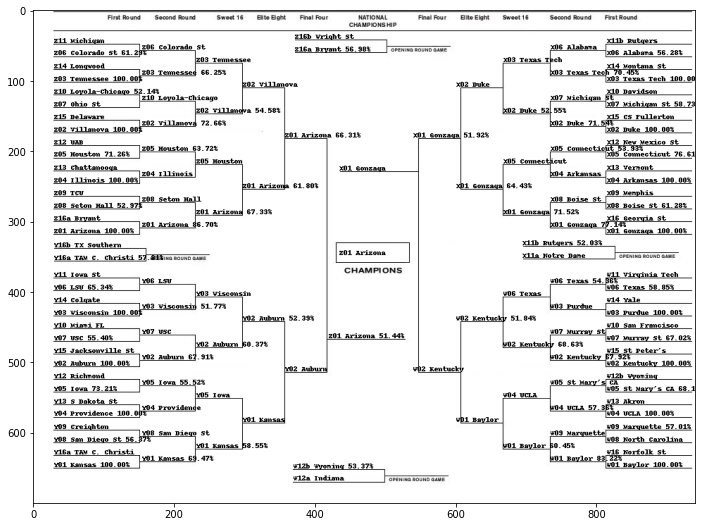

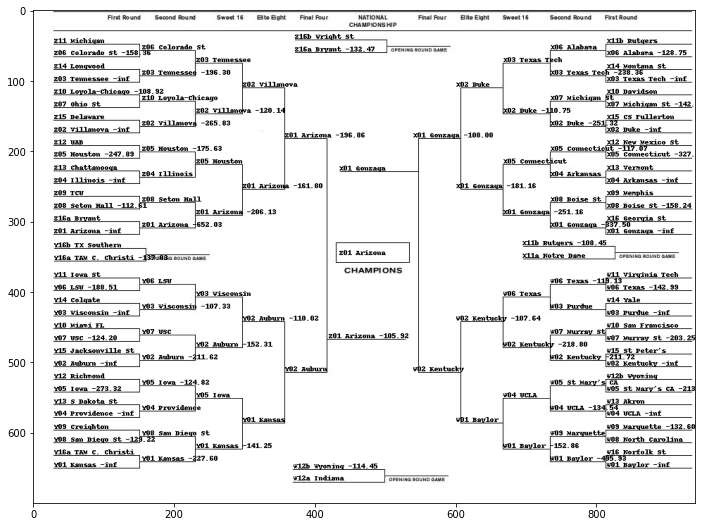

In [82]:
import sys
import os
folder_name = "march_madness"
BASE_DIR = os.path.abspath(".").split(folder_name)[0]+folder_name
#DATA_ROOT = os.path.join(BASE_DIR, "data")
sys.path.insert(0, BASE_DIR)

from generate_bracket import build_bracket

b = build_bracket(
    teamsPath=f"{DATA_DIR}MTeams.csv",
    seedsPath=f"{DATA_DIR}MNCAATourneySeeds.csv",
    slotsPath=f"{DATA_DIR}MNCAATourneySlots.csv",
    submissionPath="ncaa-march-madness-submission.csv",
    emptyBracketPath="../../empty_bracket/empty.jpg",
    year=2022
)

b = build_bracket(
    teamsPath=f"{DATA_DIR}MTeams.csv",
    seedsPath=f"{DATA_DIR}MNCAATourneySeeds.csv",
    slotsPath=f"{DATA_DIR}MNCAATourneySlots.csv",
    submissionPath="ncaa-march-madness-submission.csv",
    emptyBracketPath="../../empty_bracket/empty.jpg",
    year=2022,
    spread=True
)
